In [ ]:
import os

# 1️⃣ Paste your full secret key here:
os.environ["OPENAI_API_KEY"] = "" # Your Key Here

In [ ]:
import os
import re
import time
import pandas as pd
from bs4 import BeautifulSoup
from openai import OpenAI

# Where your downloaded filings live:
SAVE_DIR = "edgar_all_10Q"

# Initialize OpenAI client (v1+)
client = OpenAI()

# Model to use
MODEL = "gpt-4.1-mini"

In [ ]:
def extract_sections(html_path: str) -> tuple[str, str]:
    """
    Reads a local 10-Q HTML file and returns (mdna_text, risk_text).
    Splits on “Item X.” headings to locate:
      • Item 1A. Risk Factors
      • Item 2. Management’s Discussion and Analysis
    """
    raw = open(html_path, "r", encoding="utf-8").read()
    # Normalize newlines
    text = re.sub(r"\r\n?", "\n", raw)
    # Find all headings' positions
    pattern = re.compile(r"(Item\s+\d+[A]?\.)", flags=re.IGNORECASE)
    matches = list(pattern.finditer(text))
    # Append end-of-doc marker
    sections = {}
    for i, m in enumerate(matches):
        start = m.start()
        end = matches[i+1].start() if i+1 < len(matches) else len(text)
        heading = m.group(1).upper()
        sections[heading] = text[start:end].strip()
    # Extract the two targets
    risk = sections.get("ITEM 1A.", "")
    mdna = sections.get("ITEM 2.", "")
    return mdna, risk

In [ ]:
def summarize_and_rate(text: str, label: str) -> tuple[list[str], float]:
    """
    Sends one prompt to GPT-4.1 Mini to get:
      • 3-bullet summary
      • sentiment score between -1 and +1
    Returns (bullets, sentiment).
    """
    prompt = (
        f"Summarize this {label} section in three bullet points, then "
        f"provide a sentiment score from -1 (very negative) to +1 (very positive):\n\n"
        f"{text}"
    )
    resp = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        max_tokens=600
    )
    out = resp.choices[0].message.content.strip()
    # Parse bullets & sentiment from output:
    lines = [l.strip("-• ") for l in out.splitlines() if l.strip().startswith(("-", "•"))]
    # Last line (not bullet) should contain the score
    sentiment_match = re.search(r"(-?\d+(\.\d+)?)", out.splitlines()[-1])
    sentiment = float(sentiment_match.group(1)) if sentiment_match else 0.0
    return lines, sentiment

In [ ]:
import os
import time
import pandas as pd

# Map tickers to CIKs and back
CIKS = {"NVDA":"0001045810","INTC":"0000050863"}
cik_to_ticker = {v.lstrip("0"): k for k,v in CIKS.items()}

def get_recent_10qs(cik, count=16):
    subs = fetch_submissions(cik)
    forms   = subs["filings"]["recent"]["form"]
    accs    = subs["filings"]["recent"]["accessionNumber"]
    docs    = subs["filings"]["recent"]["primaryDocument"]
    dates   = subs["filings"]["recent"]["filingDate"]
    # filter & sort indices for 10-Q
    idxs = [i for i,f in enumerate(forms) if f=="10-Q"]
    idxs.sort(key=lambda i: dates[i], reverse=True)
    return [(accs[i].replace("-",""), docs[i], dates[i]) for i in idxs[:count]]

records = []

for ticker, cik in CIKS.items():
    recent = get_recent_10qs(cik, 16)
    print(f"{ticker}: processing {len(recent)} filings")

    for acc_nodash, doc, fdate in recent:
        # download if needed
        local_name = f"{cik.lstrip('0')}_{acc_nodash}{os.path.splitext(doc)[1]}"
        local_path = os.path.join(SAVE_DIR, local_name)
        if not os.path.exists(local_path):
            download_filing(cik, acc_nodash, doc)

        # extract text
        mdna_txt, risk_txt = extract_sections(local_path)
        if not mdna_txt or not risk_txt:
            print(f"  ⚠️  skipping {acc_nodash}: missing section")
            continue

        # analyze
        mdna_bullets, mdna_sent = summarize_and_rate(mdna_txt,  "MD&A")
        risk_bullets, risk_sent = summarize_and_rate(risk_txt, "Risk Factors")

        records.append({
            "ticker":         ticker,
            "filingDate":     fdate,
            "accession":      acc_nodash,
            "mdna_summary":   mdna_bullets,
            "mdna_sentiment": mdna_sent,
            "risk_summary":   risk_bullets,
            "risk_sentiment": risk_sent
        })

        time.sleep(1)

# Build & inspect
df = pd.DataFrame(records)
df.head()

NVDA: processing 16 filings
INTC: processing 16 filings


,ticker,filingDate,accession,mdna_summary,mdna_sentiment,risk_summary,risk_sentiment
0,NVDA,2024-11-20,000104581024000316,[The company repurchased 92 million shares for...,0.8,[**Supply Chain and Demand Uncertainty:** NVID...,0.0
1,NVDA,2024-08-28,000104581024000264,[NVIDIA repurchased 62.8 million shares for $7...,0.0,[**Supply Chain and Demand Uncertainty:** NVID...,0.0
2,NVDA,2024-05-29,000104581024000124,[NVIDIA’s Board approved a $25 billion increas...,0.8,[**Supply and Demand Challenges:** NVIDIA face...,0.0
3,NVDA,2023-11-21,000104581023000227,[NVIDIA repurchased 8.3 million shares for $3....,0.7,[**Supply and Demand Challenges:** NVIDIA face...,0.0
4,NVDA,2023-08-28,000104581023000175,[NVIDIA repurchased 7.5 million shares of comm...,0.8,[**Market and Product Risks:** NVIDIA faces ri...,0.0


In [ ]:
import yfinance as yf
import pandas as pd

def get_return(ticker: str, date: str, window: int = 30) -> float | None:
    """
    Download daily prices around `date` and compute the return from
    the first trading day on/after `date` to `window` trading days later.
    """
    # Build a small buffer around the filing date to ensure we hit trading days
    start = pd.to_datetime(date) - pd.Timedelta(days=3)
    end   = pd.to_datetime(date) + pd.Timedelta(days=window + 3)

    # Download price data
    df_price = yf.download(
        ticker,
        start=start.strftime("%Y-%m-%d"),
        end=end.strftime("%Y-%m-%d"),
        progress=False
    )

    if df_price.empty:
        return None

    # Pick adjusted if available, else use close
    if "Adj Close" in df_price.columns:
        series = df_price["Adj Close"]
    elif "Close" in df_price.columns:
        series = df_price["Close"]
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' in price data")

    # Normalize the index to YYYY-MM-DD strings
    series.index = series.index.strftime("%Y-%m-%d")

    # Find the first trading date on or after the filing date
    available = [d for d in series.index if d >= date]
    if not available:
        return None
    filing_day = available[0]
    base_price = series.loc[filing_day]

    # Find the price `window` trading days later
    all_dates = list(series.index)
    idx0 = all_dates.index(filing_day)
    if idx0 + window < len(all_dates):
        future_price = series.iloc[idx0 + window]
    else:
        future_price = series.iloc[-1]

    return (future_price - base_price) / base_price

In [ ]:
# Recompute returns as pure floats via list comprehension
clean_returns = []
for ticker, date in zip(df["ticker"], df["filingDate"]):
    r = get_return(ticker, date, window=5)
    # If yfinance gave a Series, take the first (and only) float value
    if hasattr(r, "__len__") and not isinstance(r, float):
        try:
            # e.g. a Series with one element
            r = float(r.iloc[0])
        except Exception:
            r = None
    clean_returns.append(r)

# Overwrite the df column
df["5d_return"] = clean_returns

# Now display
df[[
    "ticker","filingDate","accession",
    "mdna_sentiment","risk_sentiment","5d_return"
]].head()

,ticker,filingDate,accession,mdna_sentiment,risk_sentiment,5d_return
0,NVDA,2024-11-20,000104581024000316,0.8,0.0,-0.072315
1,NVDA,2024-08-28,000104581024000264,0.0,0.0,-0.154446
2,NVDA,2024-05-29,000104581024000124,0.8,0.0,0.066318
3,NVDA,2023-11-21,000104581023000227,0.7,0.0,-0.042508
4,NVDA,2023-08-28,000104581023000175,0.8,0.0,0.035743


MD&A vs 5d_return correlation: 0.160
RiskFactors vs 5d_return correlation: -0.121


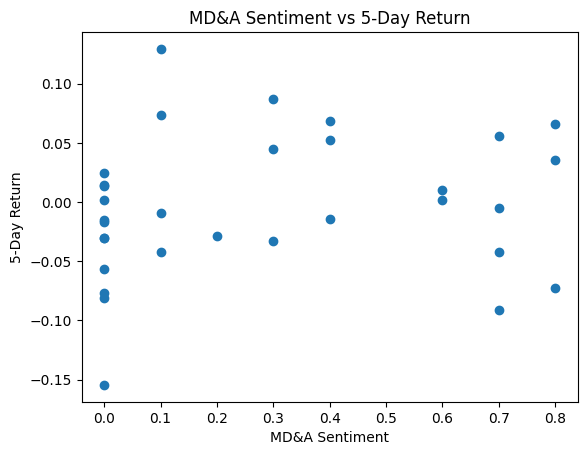

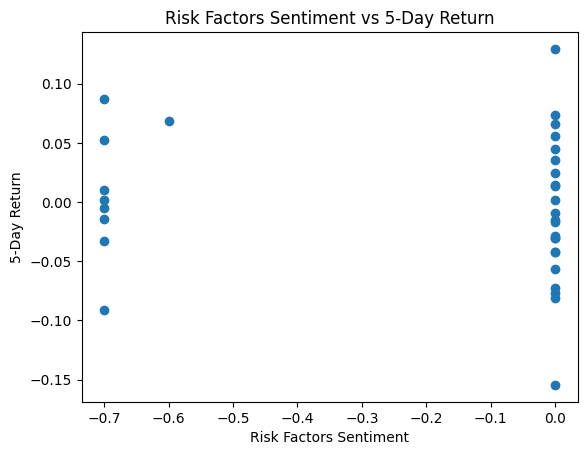

In [ ]:
import matplotlib.pyplot as plt

# 1) Compute Pearson correlations
corr_mdna = df["mdna_sentiment"].corr(df["5d_return"])
corr_risk = df["risk_sentiment"].corr(df["5d_return"])
print(f"MD&A vs 5d_return correlation: {corr_mdna:.3f}")
print(f"RiskFactors vs 5d_return correlation: {corr_risk:.3f}")

# 2) Scatter plot: MD&A Sentiment → 5-Day Return
plt.figure()
plt.scatter(df["mdna_sentiment"], df["5d_return"])
plt.xlabel("MD&A Sentiment")
plt.ylabel("5-Day Return")
plt.title("MD&A Sentiment vs 5-Day Return")
plt.show()

# 3) Scatter plot: Risk Factors Sentiment → 5-Day Return
plt.figure()
plt.scatter(df["risk_sentiment"], df["5d_return"])
plt.xlabel("Risk Factors Sentiment")
plt.ylabel("5-Day Return")
plt.title("Risk Factors Sentiment vs 5-Day Return")
plt.show()

In [ ]:
import statsmodels.api as sm

# Prepare data (drop any NaNs)
reg_df = df[["mdna_sentiment","5d_return"]].dropna()

# Add constant for intercept
X = sm.add_constant(reg_df["mdna_sentiment"])
y = reg_df["5d_return"]

# Fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              5d_return   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7844
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.383
Time:                        03:16:06   Log-Likelihood:                 45.797
No. Observations:                  32   AIC:                            -87.59
Df Residuals:                      30   BIC:                            -84.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0127      0.015     -0.

In [ ]:
# ─── Ensure price data is loaded ────────────────────────────
import yfinance as yf
import pandas as pd
import datetime as dt

# Define the date range for download
start_date = "2019-12-01"
end_date   = (dt.datetime.now() + dt.timedelta(days=30)).strftime("%Y-%m-%d")

# Download adjusted-close price series for NVDA and INTC
prices_nvda = yf.download(
    "NVDA",
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)[["Close"]]  # keep only Close (auto_adjust=True makes it adjusted)

prices_intc = yf.download(
    "INTC",
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)[["Close"]]

print("NVDA prices:", prices_nvda.shape, "INTC prices:", prices_intc.shape)

NVDA prices: (1359, 1) INTC prices: (1359, 1)


In [ ]:
# ─── Compute pre_3d_return via list comprehension ──────────────────
pre3 = []
for ticker, date in zip(df["ticker"], df["filingDate"]):
    r = get_pre_return(ticker, date, window=3)
    # if a Series sneaks through, grab its first element
    if hasattr(r, "__len__") and not isinstance(r, float):
        try:
            r = float(r.iloc[0])
        except:
            r = np.nan
    pre3.append(r)

df["pre_3d_return"] = pre3

# Sanity‐check the new column
print(df[["ticker","filingDate","pre_3d_return"]].head())

   ticker  filingDate  pre_3d_return
31   INTC  2020-04-24       0.051455
30   INTC  2020-07-24      -0.166557
29   INTC  2020-10-23      -0.097885
28   INTC  2021-04-23      -0.055183
27   INTC  2021-07-23      -0.040550


In [ ]:
print(df.columns.tolist())

['ticker', 'filingDate', 'accession', 'mdna_summary', 'mdna_sentiment', 'risk_summary', 'risk_sentiment', '5d_return', 'mdna_len', 'risk_len', 'mdna_sent_change', 'risk_sent_change', 'pre_3d_return']


In [ ]:
import statsmodels.api as sm

# 1) Specify the correct return column name
target_return = "5d_return"
print("Running regression on:", target_return)

# 2) Prepare dependent variable
y = df[target_return]

# 3) Prepare independent variables (features from Cell 9)
X = df[[
    "mdna_sentiment","risk_sentiment",
    "mdna_len","risk_len",
    "mdna_sent_change","risk_sent_change",
    "pre_3d_return"
]].copy()

# 4) Drop rows with any NaN in X or y
mask = X.notnull().all(axis=1) & y.notnull()
X_clean = X[mask]
y_clean = y[mask]

# 5) Add intercept term
X_clean = sm.add_constant(X_clean)

# 6) Fit robust OLS model
model = sm.OLS(y_clean, X_clean).fit(cov_type="HC1")
print(model.summary())

Running regression on: 5d_return
                            OLS Regression Results                            
Dep. Variable:              5d_return   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     6.845
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           0.000188
Time:                        03:19:28   Log-Likelihood:                 54.637
No. Observations:                  31   AIC:                            -93.27
Df Residuals:                      23   BIC:                            -81.80
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const  

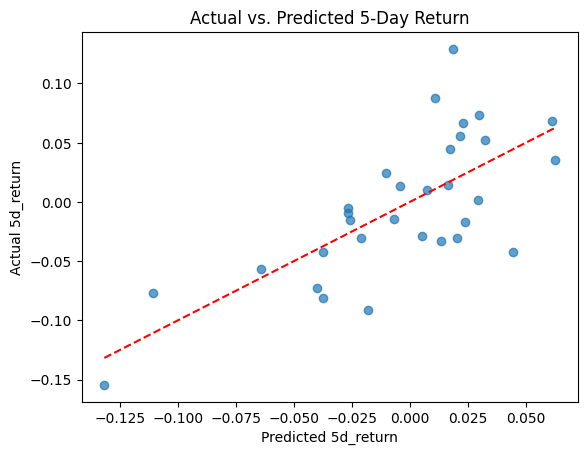

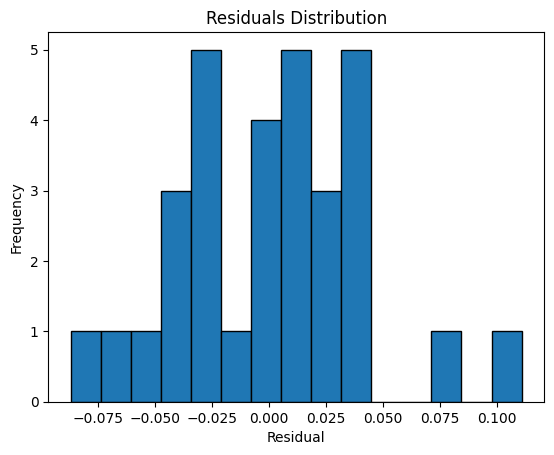

            feature        VIF
0             const   4.719862
1    mdna_sentiment  10.469429
2    risk_sentiment   1.903852
3          mdna_len   7.274925
4          risk_len  12.012516
5  mdna_sent_change   2.765943
6  risk_sent_change   2.110925
7     pre_3d_return   1.629408


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Actual vs. Predicted
preds = model.predict(X_clean)
plt.scatter(preds, y_clean, alpha=0.7)
plt.plot([preds.min(), preds.max()], [preds.min(), preds.max()], 'r--')
plt.xlabel("Predicted 5d_return")
plt.ylabel("Actual 5d_return")
plt.title("Actual vs. Predicted 5-Day Return")
plt.show()

# 2) Residual histogram
resid = y_clean - preds
plt.hist(resid, bins=15, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# 3) VIF for each predictor
vif_df = pd.DataFrame({
    "feature": X_clean.columns,
    "VIF":     [variance_inflation_factor(X_clean.values, i)
                for i in range(X_clean.shape[1])]
})
print(vif_df)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for train_idx, test_idx in kf.split(X_clean):
    X_tr, X_te = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
    y_tr, y_te = y_clean.iloc[train_idx], y_clean.iloc[test_idx]
    m = sm.OLS(y_tr, X_tr).fit()
    y_pred = m.predict(X_te)
    mse    = mean_squared_error(y_te, y_pred)        # plain MSE
    rmse   = np.sqrt(mse)                           # take sqrt for RMSE
    rmse_scores.append(rmse)

print("5-Fold CV RMSE scores:", [f"{s:.4f}" for s in rmse_scores])
print("Mean RMSE:", f"{np.mean(rmse_scores):.4f}")


5-Fold CV RMSE scores: ['0.1093', '0.0421', '0.0362', '0.0749', '0.0663']
Mean RMSE: 0.0657


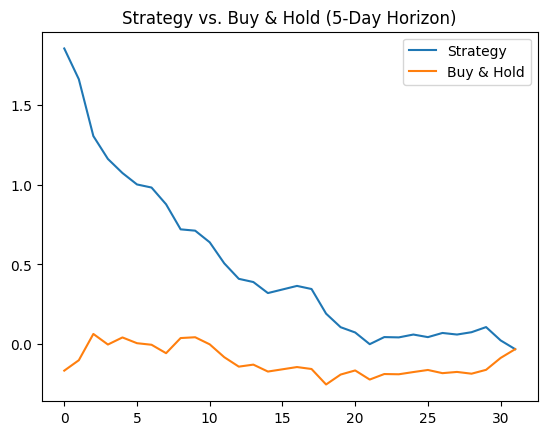

Strategy final return: 185.15%
BH    final return: -16.46%


In [ ]:
# Align preds & actual
df_cv = X_clean.copy()
df_cv["pred"] = preds
df_cv["actual"] = y_clean

# Generate signals
df_cv["signal"] = np.where(df_cv["pred"]>0, 1, -1)

# Strategy return = signal * actual
df_cv["strat_ret"] = df_cv["signal"] * df_cv["actual"]

# Cumulated returns
cum_strat = (1 + df_cv["strat_ret"]).cumprod() - 1
cum_bh    = (1 + df_cv["actual"]).cumprod() - 1

plt.plot(cum_strat, label="Strategy")
plt.plot(cum_bh,    label="Buy & Hold")
plt.legend()
plt.title("Strategy vs. Buy & Hold (5-Day Horizon)")
plt.show()

print("Strategy final return:", f"{cum_strat.iloc[-1]:.2%}")
print("BH    final return:", f"{cum_bh.iloc[-1]:.2%}")